<a href="https://colab.research.google.com/github/Jay0073/Forest-Fire-Detection/blob/main/Forest_Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [9]:
# path = '/root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3/the_wildfire_dataset_2n_version'
path = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version'

train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')
validation_dir = os.path.join(path, 'val')

In [10]:
classes = os.listdir(train_dir)
print(classes)

['nofire', 'fire']


In [11]:
# classes diversity
for i in classes:
    print(i, len(os.listdir(os.path.join(train_dir, i))))

nofire 1157
fire 730


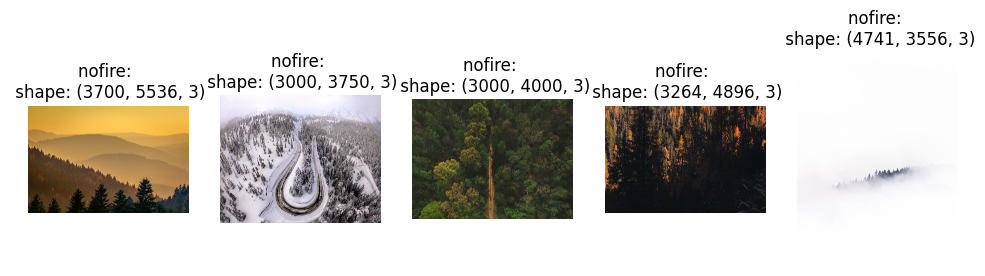

In [12]:
# class visualization
plt.figure(figsize=(12, 10))
for i in range(5):
    class_path = os.path.join(train_dir, classes[0])
    img_name = os.listdir(class_path)[i]
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{classes[0]}: \n shape: {img.shape}")
    plt.axis('off')
plt.show()

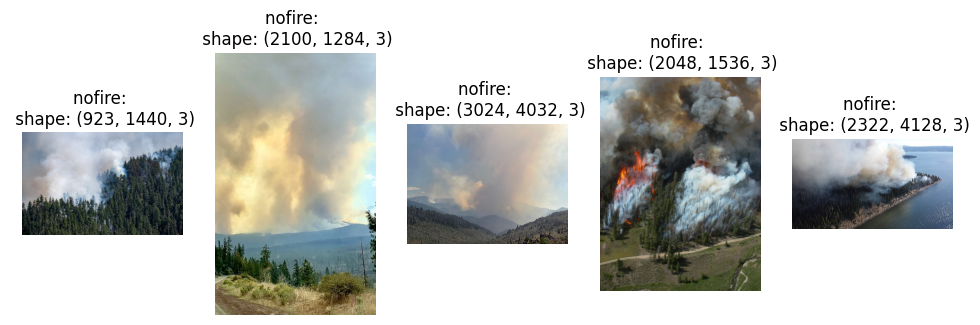

In [13]:
# class visualization

plt.figure(figsize=(12, 10)) # Now plt.figure refers to matplotlib.pyplot.figure
for i in range(5):
    class_path = os.path.join(train_dir, classes[1])
    img_name = os.listdir(class_path)[i]
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{classes[0]}: \n shape: {img.shape}")
    plt.axis('off')
plt.show()

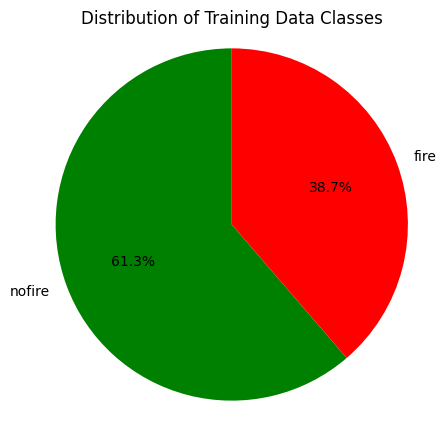

In [14]:
# Assuming train_dir is defined as before
classes = os.listdir(train_dir)
class_counts = [len(os.listdir(os.path.join(train_dir, i))) for i in classes]

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Training Data Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
def get_image_sizes(directory):
    """Gets the sizes of all images in a directory and its subdirectories."""
    sizes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = plt.imread(img_path)
                sizes.append(img.shape[:2])  # Store width and height
    return sizes

# Get image sizes for the training dataset
train_sizes = get_image_sizes(train_dir)

# Convert to NumPy array for easier calculations
train_sizes = np.array(train_sizes)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


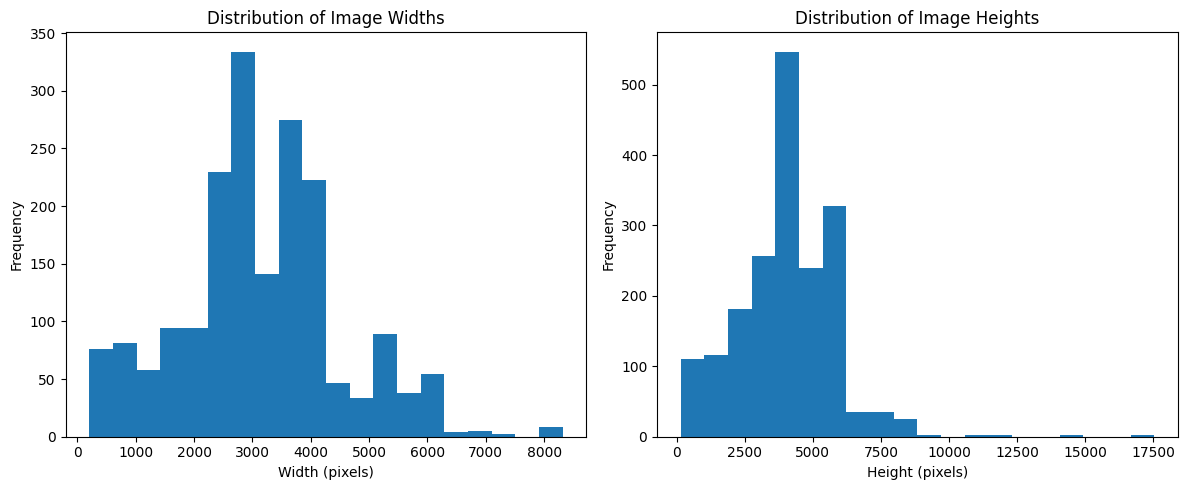

Mean Width: 3135.5702172761, Mean Height: 4027.7164811870693


In [17]:
# Create histograms to visualize size variations
plt.figure(figsize=(12, 5))

# Histogram for width
plt.subplot(1, 2, 1)
plt.hist(train_sizes[:, 0], bins=20)  # Widths are in the first column
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Histogram for height
plt.subplot(1, 2, 2)
plt.hist(train_sizes[:, 1], bins=20)  # Heights are in the second column
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

print(f"Mean Width: {np.mean(train_sizes[:, 0])}, Mean Height: {np.mean(train_sizes[:, 1])}")

In [18]:
# Preprocessing
# Image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 64 # there will be 64 images in a batch!

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

validation_data_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_data_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [19]:
# map the indices
class_mapping = train_data_generator.class_indices
print(class_mapping)

# Extract the class names
class_names = list(class_mapping.keys())
print("Class Names:", class_names)

{'fire': 0, 'nofire': 1}
Class Names: ['fire', 'nofire']


In [20]:
# Let's build the CNN Model
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
]
)

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
hist = model.fit(
    train_data_generator,
    epochs=5,  # Increased epochs for training
    validation_data=validation_data_generator,
)